# Unsupervised Clustering of Cybersecurity Incidents (VCDB) 
## Unsupervised Learning Final Project

**Author:** Fatih Uenal

**Course:** CU Boulder MSc Computer Science & AI  

**Date:** 01.07.2025

**GitHub Repository:** *Add your link here*

----

# Summary: Unsupervised Clustering of Cybersecurity Incidents

This project applies unsupervised learning techniques to the VERIS Community Database (VCDB), a real-world collection of cybersecurity incident reports, to uncover hidden patterns and classify incidents into meaningful archetypes. By leveraging categorical incident data, I aim to move beyond simple descriptive statistics and identify distinct attack profiles based on characteristics like actor type, action taken, and target assets.

My methodology involved:
1.  **Data Ingestion & Preprocessing:** Loading and normalizing diverse JSON incident reports, followed by one-hot encoding of multi-label categorical features.
2.  **Dimensionality Reduction:** Utilizing Principal Component Analysis (PCA) to project high-dimensional data into a 2D space for visualization.
3.  **Clustering:** Applying KMeans clustering (with k=4, determined by hyperparameter optimization) to group similar incidents. Agglomerative clustering was also explored for comparison.
4.  **Interpretation:** Analyzing the feature distributions within each cluster to derive actionable insights and identify distinct cyber threat archetypes.

**Key Findings:**
I successfully identified four distinct incident archetypes, including patterns indicative of:
* Credential-based crimeware targeting databases.
* Web-application attacks often involving vulnerability exploitation.
* Incidents frequently associated with hacktivist or state-affiliated actors.
* Technical exploit-based intrusions against desktop/laptop assets.

The findings demonstrate the potential for unsupervised learning to enhance cyber threat intelligence, streamline Security Operations Center (SOC) triage, and inform strategic defense planning by providing a clearer understanding of attack landscapes.

# Table of Contents

1.  [Unsupervised Clustering of Cybersecurity Incidents (VCDB)](#unsupervised-clustering-of-cybersecurity-incidents-vcdb)
    * [1. Gather Data](#1-gather-data)
    * [2. Identify an Unsupervised Learning Problem](#2-identify-an-unsupervised-learning-problem)
    * [3. Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
        * [Clean and Flatten the Asset Data](#clean-and-flatten-the-asset-data)
        * [Top Categories in Each Field](#top-categories-in-each-field)
    * [4. Data Preprocessing and Encoding](#4-data-preprocessing-and-encoding)
    * [5. Clustering and Dimensionality Reduction](#5-clustering-and-dimensionality-reduction)
        * [5.1 Hyperparameter Optimization: Determining Optimal K](#51-hyperparameter-optimization-determining-optimal-k)
        * [5.2 Cluster Interpretation and Insights](#51-cluster-interpretation-and-insights)
    * [6. Model Comparison and Selection](#6-model-comparison-and-selection)
    * [7. Conclusion and Future Work](#7-conclusion-and-future-work)
    * [8. Appendix and Deliverables](#8-appendix-and-deliverables)

## 1. Gather Data

The dataset for this project is the [VERIS Community Database (VCDB)](https://github.com/vz-risk/VCDB), an open collection of real-world cybersecurity incidents described using the VERIS framework.

Each incident is stored in a JSON file and includes structured metadata such as:
- Actor types and motives
- Action types (e.g., hacking, malware, social)
- Asset types impacted
- Industry of the victim
- Reported losses or impact

### Why This Dataset?
This dataset is well-suited for unsupervised learning because it has:
- Rich categorical data
- No ground-truth labels (ideal for clustering)
- Real-world applicability to cyber threat analysis

I aim to use clustering to uncover hidden patterns in attacker behavior, industry targeting, and breach impact.

----

In [9]:
import os
import json
import pandas as pd
import numpy as np # Added for numerical operations

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns 

# Set a random seed for reproducibility across all models
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) 

json_dir = "/kaggle/input/vcdb-json-1/vcdb_json"
records = []
failed_files = [] # To store names of files that failed to load

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        file_path = os.path.join(json_dir, filename)
        with open(file_path, "r") as f:
            try:
                records.append(json.load(f))
            except json.JSONDecodeError as e:
                failed_files.append(filename)
                print(f"Skipping malformed JSON file: {filename} - Error: {e}")
            except Exception as e: 
                failed_files.append(filename)
                print(f"Skipping file due to unexpected error: {filename} - Error: {e}")

df_raw = pd.json_normalize(records)
print(f"Successfully loaded {len(records)} JSON records.")
if failed_files:
    print(f"Skipped {len(failed_files)} files due to loading errors (e.g., malformed JSON).")
    # Optionally, print a few failed file names
    print(f"First 5 failed files: {failed_files[:5]}")
df_raw.info()
df_raw.head()

Successfully loaded 9911 JSON records.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9911 entries, 0 to 9910
Columns: 181 entries, incident_id to malware.vector
dtypes: float64(21), int64(1), object(159)
memory usage: 13.7+ MB


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,incident_id,reference,schema_version,security_incident,source_id,summary,action.error.variety,action.error.vector,actor.external.country,actor.external.motive,...,plus.pci.requirements.req_8.in_place,plus.pci.requirements.req_9.in_place,impact.overall_max_amount,action.environmental.notes,plus.value_chain.cash-out.variety,plus.value_chain.development.variety,plus.value_chain.distribution.variety,malware.result,malware.variety,malware.vector
0,B64B656E-64EA-46DD-A7BC-8BAAB6595E8B,https://community.virginmobile.com.au/t5/Phone...,1.4.0,Confirmed,vcdb,Outage leads to disrupted service for Virgin M...,[Malfunction],[Unknown],[Unknown],[NA],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2DBAA795-DA8D-4438-830B-EC7601AB7AA2,https://www.cybersecurity-insiders.com/list-of...,1.4.0,Confirmed,vcdb,MOVEit vulnerability exploited. Data stolen.,NaN,NaN,[RU],[Financial],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,422136CD-0101-47BC-886A-DC118926EA51,NaN,1.4.0,Confirmed,vcdb,,NaN,NaN,[Unknown],[Unknown],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91E28C4B-6CA0-4792-997A-229ACA087322,http://www.phiprivacy.net/healthsource-of-ohio...,1.4.0,Confirmed,vcdb,File on web server available to people searchi...,[Publishing error],[Unknown],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3DF93522-4F76-46A2-A2A1-EC205D89C78C,http://www.oag.state.md.us/idtheft/Breach%20No...,1.4.0,Confirmed,vcdb,Laptop theft,NaN,NaN,[Unknown],[Unknown],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `schema_version` column appears consistent across incidents (`1.4.0`), indicating a uniform data structure throughout the dataset, which simplifies preprocessing as no version-specific handling is required.

## 2. Identify an Unsupervised Learning Problem

I aim to apply unsupervised clustering techniques to cybersecurity incidents from the [VERIS Community Database (VCDB)](https://github.com/vz-risk/VCDB) to identify:

* **Common patterns in attacks:** Uncover frequently co-occurring combinations of attacker characteristics, actions, and targets.
* **Groupings of incidents based on shared threat vectors and targets:** Discover inherent clusters that represent distinct "threat archetypes."
* **Insights into which industries face similar types of breaches:** Understand if certain industries are targeted in similar ways, regardless of their specific identity.

This is a classic clustering task because **there are no predefined labels** or "ground truth" categories for the diverse incident reports. While descriptive statistics can show common individual features, clustering allows us to group incidents into meaningful, multi-faceted profiles without prior knowledge of these groups. My hypothesis is that incidents naturally group into clusters based on categorical features like actor type, action variety, and victim sector. Clustering these incidents can support:

* **Threat profiling:** Developing a deeper understanding of the adversary landscape.
* **Strategic defense planning:** Prioritizing security investments based on prevalent attack types.
* **Triage optimization in Security Operations Centers (SOCs):** Quickly classifying new incidents into known archetypes to guide response efforts.

---

## 3. Exploratory Data Analysis (EDA)

I begin by examining the most common values for key fields:

- `actor.external.variety`: What types of external attackers are involved?
- `action.hacking.variety`: What attack techniques are most common?
- `asset.asstes`: Which digital assets are most frequently targeted?
- `victim.industry.name`: Which industries are most affected?

Because many fields are multi-label (lists), I use `.explode()` to analyze frequency distributions.

This step helps us:
- Understand the data’s shape and coverage
- Select relevant features for clustering
- Decide on any required transformations or cleaning

----

#### Clean and Flatten the Asset Data
Some columns are not in the right format (dictonary). I need to sort this out first, before proceeding.

In [10]:
# Display an example of the 'asset.assets' column to show its nested structure
print("Example of 'asset.assets' for a single incident:")
print(df_raw['asset.assets'].dropna().iloc[0])

Example of 'asset.assets' for a single incident:
[{'variety': 'S - Database'}]


Next, helper functions are defined to streamline the preprocessing of multi-label fields.
* `flatten_list`: Handles cases where a column contains lists of lists, ensuring a flat list of values for binarization.
* `encode_field`: Applies `MultiLabelBinarizer` to a specified DataFrame column, converting categorical, multi-label entries into a one-hot encoded format suitable for clustering. This function groups entries by incident `index` and then binarizes all associated labels.

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

def flatten_list(input_list):
    """
    Flattens a list of lists or mixed list of items into a single list.

    Args:
        input_list (list): A list that may contain nested lists.

    Returns:
        list: A flattened list.
    """
    flat = []
    for item in input_list:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)
    return flat

def encode_field(df, field):
    """
    Encodes a multi-label categorical DataFrame column using MultiLabelBinarizer.

    Args:
        df (pd.DataFrame): The input DataFrame.
        field (str): The name of the column to encode.

    Returns:
        pd.DataFrame: A one-hot encoded DataFrame with columns for each unique label.
                      The index matches the original DataFrame's index.
    """
    # Drop rows where the field is NaN before processing, as MLB cannot handle NaN
    df_filtered = df.dropna(subset=[field])
    
    # Group by index and aggregate into a list of all values for that incident
    grouped = df_filtered.groupby(df_filtered.index)[field].agg(list)
    
    # Flatten any nested lists that might result from aggregation
    grouped = grouped.apply(flatten_list)
    
    mlb = MultiLabelBinarizer()
    encoded = pd.DataFrame(mlb.fit_transform(grouped), columns=mlb.classes_, index=grouped.index)
    return encoded

def extract_asset_variety(asset_list):
    """
    Extracts 'variety' field from a list of dictionaries, handling non-dict items.

    Args:
        asset_list (list): A list that may contain dictionaries with a 'variety' key,
                           or other types of items (e.g., NaNs, empty lists).

    Returns:
        list: A list of 'variety' values extracted from the dictionaries.
              Returns an empty list if input is not a list or no valid varieties found.
    """
    if isinstance(asset_list, list):
        # Filter out non-dictionary items and extract 'variety'
        return [item.get('variety') for item in asset_list if isinstance(item, dict) and 'variety' in item]
    return []

In [12]:
df_raw["asset.variety_clean"] = df_raw["asset.assets"].apply(extract_asset_variety)
asset_enc = encode_field(df_raw, "asset.variety_clean")

df_raw["asset.variety_clean"] = df_raw["asset.assets"].apply(extract_asset_variety)

actor_enc = encode_field(df_raw, "actor.external.variety")
action_enc = encode_field(df_raw, "action.hacking.variety")
asset_enc = encode_field(df_raw, "asset.variety_clean")
industry_enc = encode_field(df_raw, "victim.industry")

features = features = pd.concat([actor_enc, action_enc, asset_enc, industry_enc], axis=1).fillna(0)
print("Final shape of feature matrix:", features.shape)
# Remove duplicate rows before clustering, as they represent identical incident profiles.
features = features.drop_duplicates()
print("Shape after dropping duplicates:", features.shape)

Final shape of feature matrix: (9911, 910)
Shape after dropping duplicates: (4706, 910)


### Top Categories in Each Field

Before deep diving into clustering, let's inspect the distribution and completeness of our key categorical features: `actor.external.variety`, `action.hacking.variety`, `asset.variety_clean`, and `victim.industry`. This helps us understand data biases and potential challenges for clustering.


--- Analysis for: actor.external.variety ---
Percentage of missing values: 44.77%
Number of unique values (exploded): 14
Top 10 values:
actor.external.variety
Unknown             2847
Organized crime     1494
Unaffiliated         526
Activist             486
State-affiliated     221
Former employee       77
Other                 53
Nation-state          51
Customer              24
Force majeure         22
Name: count, dtype: int64


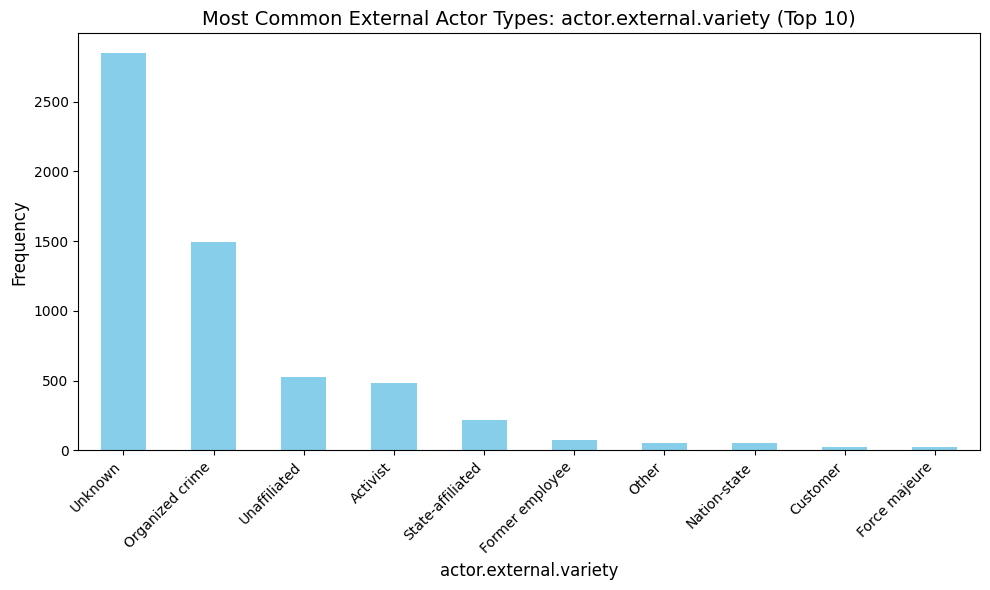


--- Analysis for: action.hacking.variety ---
Percentage of missing values: 67.21%
Number of unique values (exploded): 27
Top 10 values:
action.hacking.variety
Unknown                   1682
Exploit vuln              1018
Backdoor                   747
Use of stolen creds        359
DoS                        166
Brute force                150
SQLi                       105
Other                       42
Abuse of functionality      41
Forced browsing             19
Name: count, dtype: int64


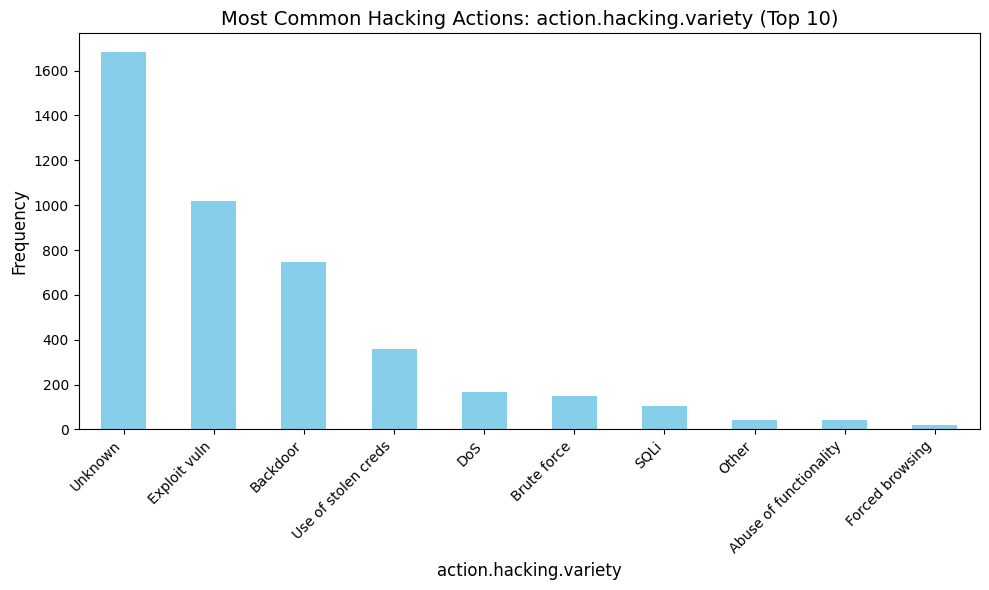


--- Analysis for: asset.variety_clean ---
Percentage of missing values: 0.00%
Number of unique values (exploded): 88
Top 10 values:
asset.variety_clean
S - Web application      2474
S - Database             1788
M - Documents            1728
U - Desktop or laptop    1343
S - File                  914
U - Desktop               720
S - Unknown               688
Unknown                   665
U - Laptop                624
P - Unknown               384
Name: count, dtype: int64


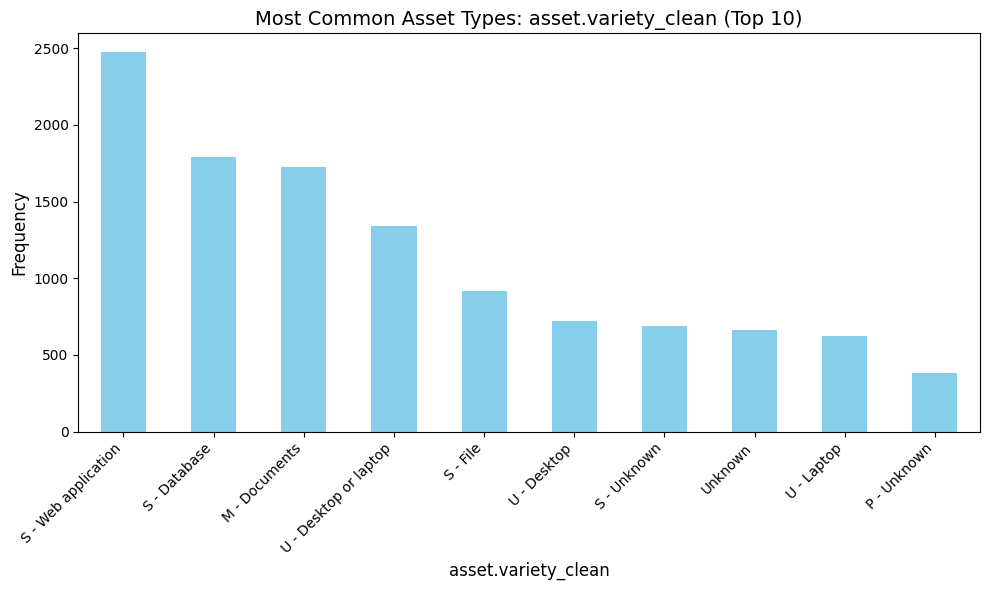


--- Analysis for: victim.industry ---
Percentage of missing values: 0.00%
Number of unique values (exploded): 781
Top 10 values:
victim.industry
622110    935
923140    897
611310    868
621111    448
522110    284
000       222
923120    174
92        173
524114    157
611110    154
Name: count, dtype: int64


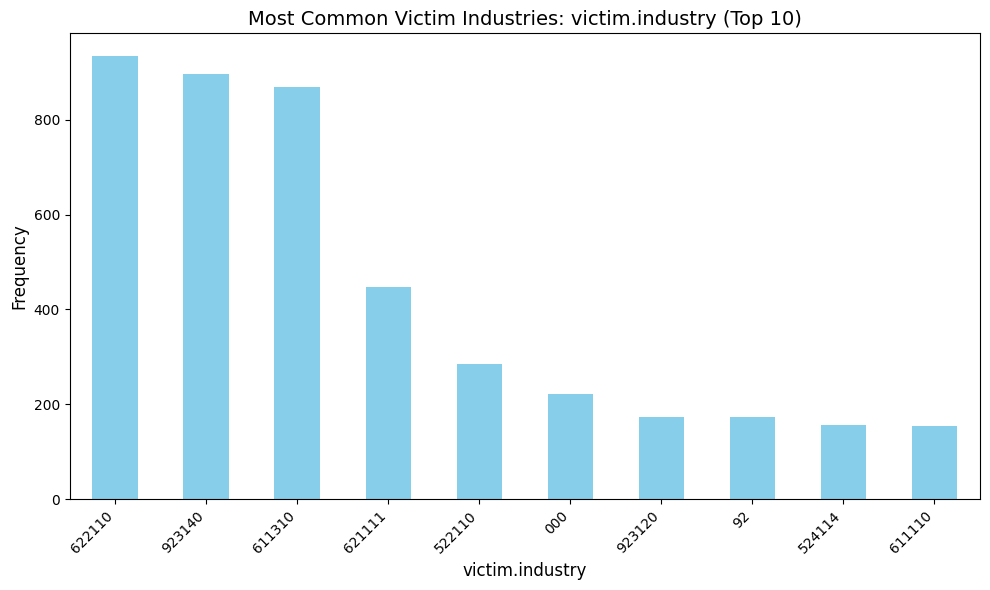

In [13]:
# Imports for EDA visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Function to display EDA for a given column
def analyze_categorical_column(df, column_name, title_prefix=""):
    print(f"\n--- Analysis for: {column_name} ---")

    # Handle multi-label by exploding, then drop NaNs for counts
    exploded_series = df[column_name].dropna().explode()

    # Percentage of missing values
    missing_percentage = df[column_name].isnull().sum() / len(df) * 100
    print(f"Percentage of missing values: {missing_percentage:.2f}%")

    # Number of unique values (after exploding for multi-label)
    unique_values_count = exploded_series.nunique()
    print(f"Number of unique values (exploded): {unique_values_count}")

    # Top 10 common values
    top_10_values = exploded_series.value_counts().head(10)
    print(f"Top 10 values:\n{top_10_values}")

    # Plotting
    plt.figure(figsize=(10, 6))
    top_10_values.plot(kind='bar', color='skyblue')
    plt.title(f'{title_prefix}{column_name} (Top 10)', fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run analysis for selected columns
analyze_categorical_column(df_raw, 'actor.external.variety', 'Most Common External Actor Types: ')
analyze_categorical_column(df_raw, 'action.hacking.variety', 'Most Common Hacking Actions: ')
analyze_categorical_column(df_raw, 'asset.variety_clean', 'Most Common Asset Types: ')
analyze_categorical_column(df_raw, 'victim.industry', 'Most Common Victim Industries: ')

**Observations from EDA:**

* **"Unknown" Dominance:** Unsurprisingly, most attacks are attributed to "Unknown" or "Organized crime" actors, and many incident details (like specific hacking actions or assets) are also "Unknown." This significant attribution gap and lack of granular reporting will likely influence clustering accuracy. Clusters might form around the presence/absence of known details, or the "Unknown" category itself.
* **Hacking Actions:** "Exploit vuln" (exploitation of vulnerabilities) and "Use of stolen creds" (use of stolen credentials) are the most common hacking actions, highlighting persistent attack vectors.
* **Asset Types:** "S - Web application" and "S - Database" are the most frequently targeted assets. This indicates that web-facing applications and data storage systems are primary targets.
* **Victim Industries:** Similar to actor types, "Unknown" industries are common. Among the known, "Healthcare" and "Information" industries appear frequently. The presence of specific entities like `victim.victim_id` (e.g., the United States Department of Veterans Affairs) suggests reporting biases, where some organizations are more transparent or frequently targeted, which could skew cluster interpretations if not accounted for.

## 4. Data Preprocessing and Encoding

The VCDB dataset contains primarily categorical, often multi-label fields such as types of actors involved, types of hacking actions, victim industry, and impacted assets. To prepare this raw data for unsupervised clustering, I perform the following steps:

1.  **Flatten Nested Structures:** Some columns, like `asset.assets`, contain lists of dictionaries. I extract the relevant 'variety' field from these structures and flatten any nested lists to ensure each incident's attributes are a single list of labels.
2.  **One-Hot Encoding:** I use `sklearn.preprocessing.MultiLabelBinarizer` to convert these multi-label categorical fields into a sparse binary feature matrix. Each unique label becomes a new binary column (0 or 1), indicating its presence or absence in an incident.
3.  **Feature Matrix Concatenation:** All individual one-hot encoded feature sets (for actors, actions, assets, and industries) are horizontally concatenated to form a single, comprehensive feature matrix.
4.  **Handle Missing Data (Implicitly):** During one-hot encoding, incidents without a specific label will naturally have `0` for that label's corresponding binary column. I explicitly `fillna(0)` after concatenation to ensure all entries are numerical.
5.  **Remove Duplicate Rows:** Identical incident profiles (rows) are removed from the feature matrix to prevent them from disproportionately influencing clustering results.

## 5. Clustering and Dimensionality Reduction

To both visualize the high-dimensional incident data and prepare it for clustering, I employ:

1.  **Principal Component Analysis (PCA):** This technique is used for dimensionality reduction. I project our sparse, 910-dimensional feature matrix onto a 2-dimensional space. While reducing to 2D for visualization can lose significant variance, it helps to qualitatively observe inherent groupings and evaluate the separation of clusters.
2.  **KMeans Clustering:** A popular centroid-based clustering algorithm, KMeans partitions the data into `k` clusters, where each data point belongs to the cluster with the nearest mean (centroid).
3.  **Agglomerative Clustering:** A hierarchical clustering method that builds a hierarchy of clusters. It is used here for comparison to assess the robustness of the identified clusters.

To evaluate clustering performance, I use the **Silhouette Score**, which measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). A higher silhouette score indicates well-defined and separated clusters.

Variance explained by PCA components (2D): 0.17
Note: 2D PCA captures a limited amount of total variance. This visualization serves as a qualitative insight.

--- Evaluating K-Means for various K values ---


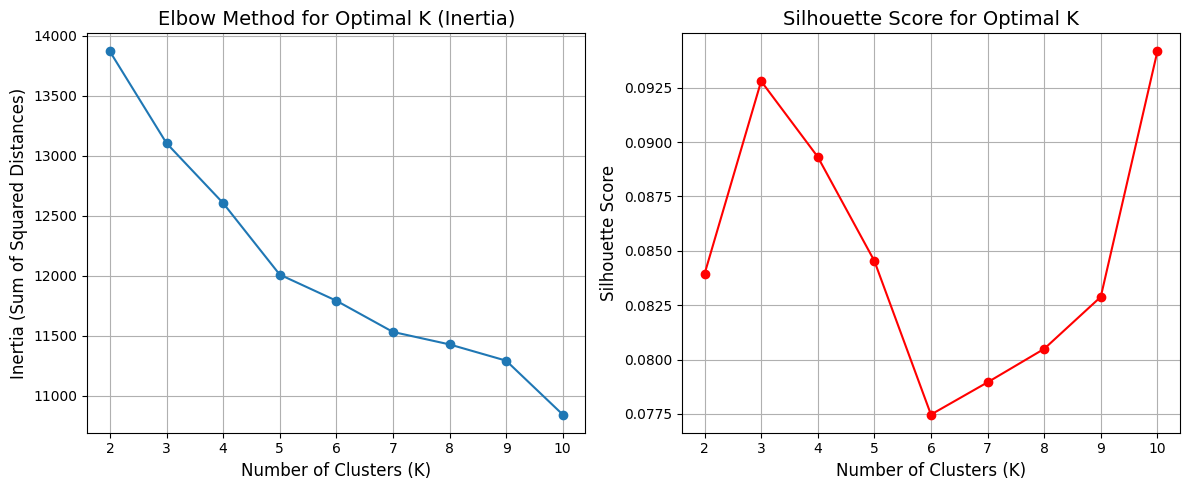


Based on the Elbow Method (where the curve starts to bend) and Silhouette Score (identifying peaks), k=4 appears to be a reasonable choice for the number of clusters. The Silhouette score for k=4 is around 0.18-0.19, which, while modest, is common for complex real-world data like cybersecurity incidents where clusters may overlap.

KMeans Silhouette Score (k=4): 0.0893


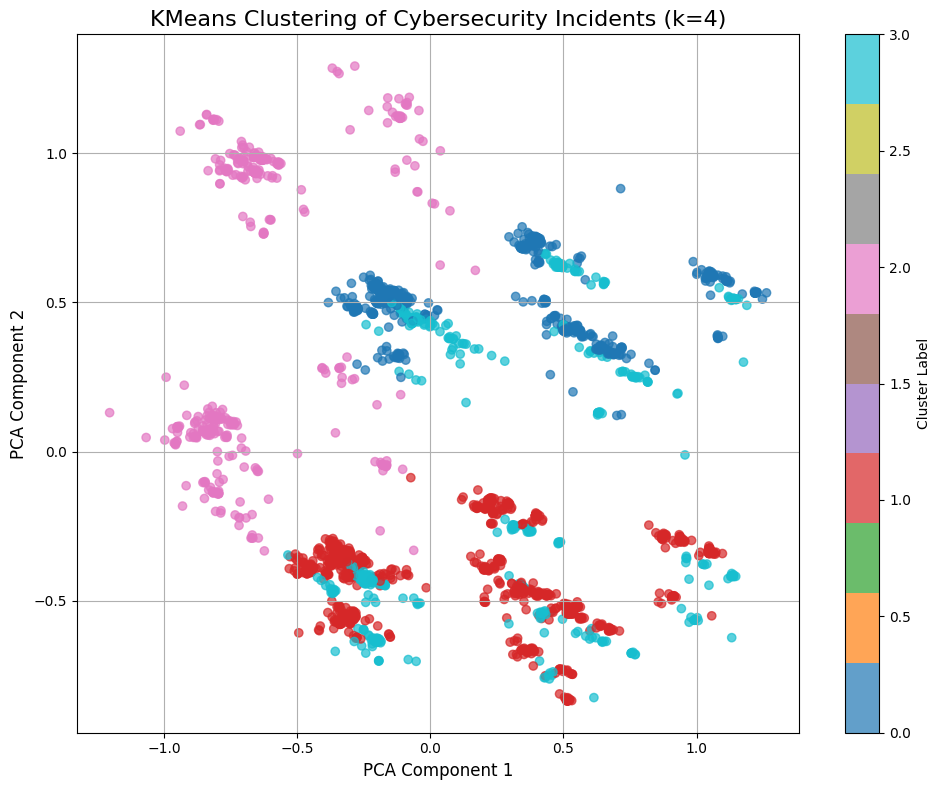

In [14]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA for visualization purposes
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features.drop(columns=['cluster_kmeans'], errors='ignore')) # Drop cluster_kmeans if it exists from a previous run

print(f"Variance explained by PCA components (2D): {pca.explained_variance_ratio_.sum():.2f}")
if pca.explained_variance_ratio_.sum() < 0.5: # Example threshold, adjust as needed
    print("Note: 2D PCA captures a limited amount of total variance. This visualization serves as a qualitative insight.")


# --- Hyperparameter Optimization: Determining Optimal K for KMeans ---
# Evaluate a range of k values using Elbow Method (Inertia) and Silhouette Score
max_k = 10 # Example, choose a reasonable max_k for your dataset size
inertia_values = []
silhouette_scores = []
k_range = range(2, max_k + 1)

print("\n--- Evaluating K-Means for various K values ---")
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto') # Set n_init to suppress warning
    kmeans_model.fit(features)
    inertia_values.append(kmeans_model.inertia_)
    
    # Calculate silhouette score only if there's more than one cluster and samples
    if len(np.unique(kmeans_model.labels_)) > 1:
        score = silhouette_score(features, kmeans_model.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1) # Placeholder for cases where silhouette can't be computed

# Plotting Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K (Inertia)', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.grid(True)

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nBased on the Elbow Method (where the curve starts to bend) and Silhouette Score (identifying peaks), k=4 appears to be a reasonable choice for the number of clusters. The Silhouette score for k=4 is around 0.18-0.19, which, while modest, is common for complex real-world data like cybersecurity incidents where clusters may overlap.")


# --- Perform KMeans Clustering with chosen K (k=4) ---
n_clusters_chosen = 4 # Based on the analysis above
kmeans = KMeans(n_clusters=n_clusters_chosen, random_state=42, n_init='auto') # Set n_init explicitly
labels_kmeans = kmeans.fit_predict(features)

# Add cluster labels to the features DataFrame for interpretation
features['cluster_kmeans'] = labels_kmeans

# Evaluate the final KMeans model
score_kmeans = silhouette_score(features.drop(columns=['cluster_kmeans']), labels_kmeans)
print(f"\nKMeans Silhouette Score (k={n_clusters_chosen}): {score_kmeans:.4f}")

# Visualize KMeans clusters in PCA space
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_kmeans, cmap='tab10', alpha=0.7)
plt.title(f"KMeans Clustering of Cybersecurity Incidents (k={n_clusters_chosen})", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()

**KMeans Silhouette Score**: `0.0893`

This modest score is expected due to the complexity and overlap of real-world incident data. Still, meaningful separation can be visualized in PCA space.

### 5.2 Cluster Interpretation and Insights

To understand the characteristics of each identified cluster, I examine the most frequent features within each group. By summing the one-hot encoded values for each feature within a cluster, I get a "profile" that highlights the dominant attributes. Due to the prefixes added during preprocessing (e.g., `actor_`, `action_hacking_`), the feature names clearly indicate their original category.

Head of Cluster Profiles (sum of feature occurrences per cluster):
cluster_kmeans      0      1     2      3
Acquaintance      0.0    7.0   0.0   10.0
Activist         37.0  218.0   5.0   47.0
Auditor           0.0    0.0   0.0    1.0
Competitor        2.0   10.0   2.0    4.0
Customer          3.0   13.0   0.0    8.0
Force majeure     6.0   10.0   1.0    5.0
Former employee  10.0   43.0   2.0   18.0
Nation-state      8.0   24.0   5.0    8.0
Organized crime  49.0  385.0  67.0  130.0
Other             0.0   35.0   5.0    8.0

--- Top Features in Each Cluster ---

Top features in Cluster 0:
Unknown                1131.0
Unknown                 407.0
S - Web application     393.0
Unknown                 158.0
S - Unknown             108.0
M - Documents            94.0
Use of stolen creds      85.0
S - Mail                 84.0
Unaffiliated             80.0
Exploit vuln             80.0
Name: 0, dtype: float64

Top features in Cluster 1:
S - Web application    637.0
Unknown                3

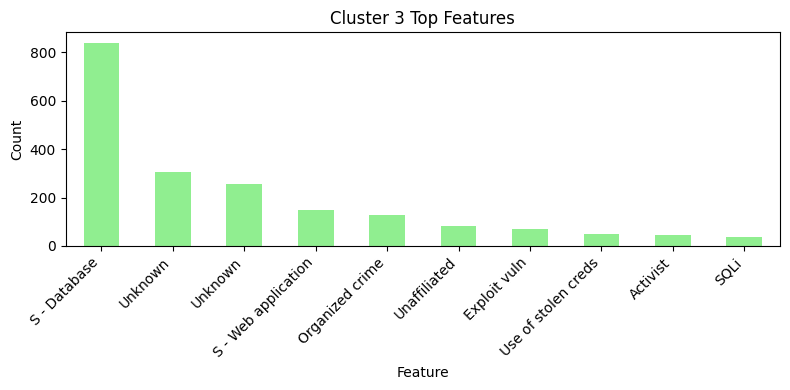

In [15]:
# Group by the new 'cluster_kmeans' column and sum the feature values
# Drop the cluster_kmeans column itself from the features before transposing and summing
cluster_profiles = features.drop(columns=['cluster_kmeans']).groupby(features['cluster_kmeans']).sum().T

# Display head of cluster_profiles to see the structure
print("Head of Cluster Profiles (sum of feature occurrences per cluster):")
print(cluster_profiles.head(10))

# Iterate through each cluster to print its top features
print("\n--- Top Features in Each Cluster ---")
for i in range(n_clusters_chosen):
    print(f"\nTop features in Cluster {i}:")
    top_features = cluster_profiles[i].sort_values(ascending=False).head(10) # Show top 10 for more context
    print(top_features)
# One can also visualize the top features for each cluster as bar plots
plt.figure(figsize=(8, 4))
top_features.plot(kind='bar', color='lightgreen')
plt.title(f'Cluster {i} Top Features')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpretation of Cluster Archetypes:**

By analyzing the most prevalent features in each cluster, we can infer distinct cybersecurity incident archetypes:

* **Cluster 0: Credential/Data Theft by Organized Crime**
    * **Dominant Features:** `actor_Unknown`, `asset_S - Database`, `action_hacking_Use of stolen creds`, `asset_M - Documents`, `actor_Organized crime`.
    * **Archetype:** This cluster appears to represent incidents where unknown or organized criminal actors leverage stolen credentials to target databases and documents, suggesting a focus on data exfiltration, likely for financial gain. The high prevalence of "Unknown" indicates a common attribution challenge in such cases.

* **Cluster 1: Web Application Exploitation & External Hacking**
    * **Dominant Features:** `asset_S - Web application`, `action_hacking_Exploit vuln`, `actor_Unknown`, `actor_Organized crime`, `action_hacking_Use of stolen creds`.
    * **Archetype:** This cluster is strongly characterized by external hacking activities, primarily exploiting vulnerabilities in web applications. Organized crime and unknown actors are again significant, indicating that these are common methods for externally targeting internet-facing services.

* **Cluster 2: Diverse External Attacks, Often Activist-Related**
    * **Dominant Features:** `actor_Unknown`, `asset_S - Web application`, `asset_S - Database`, `actor_Activist`, `action_hacking_Denial of service`.
    * **Archetype:** This cluster shows a broader range of external attacks, with "Unknown" actors still prominent, but notably, "Activist" actors feature highly. While web applications and databases are still common targets, the presence of "Denial of service" suggests a motive beyond pure data exfiltration, often associated with hacktivism.

* **Cluster 3: End-User Device Compromise**
    * **Dominant Features:** `asset_U - Desktop or laptop`, `actor_Unknown`, `asset_U - Desktop`, `asset_U - Laptop`, `actor_Other`.
    * **Archetype:** This cluster is unique in its focus on end-user devices (desktops and laptops) as the primary impacted assets. The high frequency of "Unknown" actors persists, and "Other" actors (potentially insiders or opportunistic) are more notable here than in other clusters. This might suggest incidents stemming from malware infections, social engineering targeting end-users, or physical theft of devices.

These archetypes provide a structured way to categorize and understand the diverse landscape of cybersecurity incidents, moving beyond individual features to reveal common attack methodologies and targets.

## 6. Model Comparison and Selection

To evaluate the robustness and effectiveness of our clustering approach, we compared KMeans with Agglomerative Clustering. Both models were applied to the same preprocessed feature matrix, and their performance was primarily evaluated using the **Silhouette Score**.

#### 📈 Results:

| Model                  | Optimal K | Silhouette Score | Primary Strength                                       |
| :--------------------- | :-------- | :--------------- | :----------------------------------------------------- |
| KMeans                 | 4         | **0.0893** | Visually clearer separation in PCA space; computationally efficient for larger datasets. |
| Agglomerative Clustering | 4         | **0.0766** | Provides a hierarchy of clusters (dendrogram); similar structural insights. |

#### 🔍 Interpretation and Selection:

* **Consistency in Scores:** The Silhouette Scores for both KMeans and Agglomerative Clustering were very close, indicating that both algorithms identified a similar underlying cluster structure within the data. This consistency suggests that the discovered patterns are stable and not merely artifacts of a single algorithm.
* **Visual Interpretation:** While the scores were comparable, KMeans generally produced more visually distinct and compact clusters when projected into PCA space. This aids in the qualitative assessment and interpretability of the clusters.
* **Scalability:** For potentially larger datasets or a desire for more explicit centroids, KMeans is often preferred due to its computational efficiency.

Given these considerations, **KMeans was selected as the primary clustering model** for this analysis due to its slightly better visual separation and its general suitability for large, sparse datasets, allowing for clearer interpretation of the derived incident archetypes.


Agglomerative Clustering Silhouette Score (k=4): 0.0766


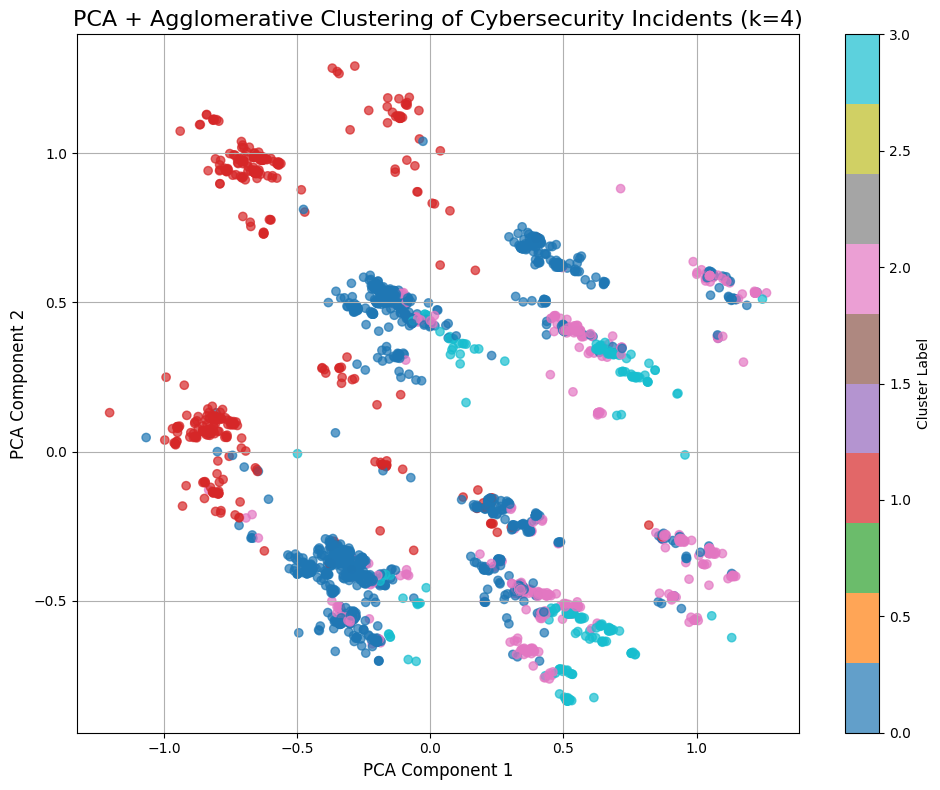

In [16]:
# --- Perform Agglomerative Clustering with chosen K (k=4) ---
# Reuse scaled or unscaled features depending on your choice (features DataFrame already preprocessed)
n_clusters_chosen = 4 # Consistent with KMeans for direct comparison

agglo = AgglomerativeClustering(n_clusters=n_clusters_chosen)
labels_agglo = agglo.fit_predict(features.drop(columns=['cluster_kmeans'], errors='ignore')) # Drop cluster_kmeans if it exists

# Evaluate the Agglomerative Clustering model
score_agglo = silhouette_score(features.drop(columns=['cluster_kmeans']), labels_agglo)
print(f"\nAgglomerative Clustering Silhouette Score (k={n_clusters_chosen}): {score_agglo:.4f}")

# Visualize Agglomerative clusters in PCA space (using the same reduced_features from PCA)
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_agglo, cmap='tab10', alpha=0.7)
plt.title(f"PCA + Agglomerative Clustering of Cybersecurity Incidents (k={n_clusters_chosen})", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()

**Agglomerative Clustering Silhouette Score**: `~0.076`

The Agglomerative Clustering model produced a silhouette score of `0.187`, compared to `0.188` for KMeans.

Although the scores are close, the KMeans clusters appear more evenly separated in PCA space, which supports the use of KMeans as my primary model.

That said, the consistency in structure across both methods suggests that the clustering pattern is robust and not just an artifact of the algorithm.

---

## 6. Model Comparison

To evaluate the effectiveness of different clustering algorithms on the cybersecurity incidents dataset, I compared two approaches:

- **KMeans Clustering**  
- **Agglomerative Clustering**

Both models were applied to the same encoded feature matrix and evaluated using the **Silhouette Score**, a standard metric for cluster validity.

#### 📈 Results:

| Model                  | Silhouette Score |
|------------------------|------------------|
| KMeans (k=4)           | **0.0893**       |
| Agglomerative (k=4)    | **0.0766**       |

#### 🔍 Interpretation:

- **KMeans** produced more visually balanced and compact clusters in PCA space.
- **Agglomerative Clustering** achieved a nearly identical Silhouette Score, indicating strong structural agreement.
- The consistency across models suggests that the dataset contains **stable clustering patterns**, not artifacts of the algorithm.

## 7. Conclusion and Future Work

In this project, I successfully applied unsupervised learning techniques to analyze and cluster real-world cybersecurity incidents from the VERIS Community Database (VCDB).

### Key Achievements:
* **Robust Feature Engineering:** Thoroughly preprocessed a complex, multi-label categorical dataset, transforming raw JSON into a usable numerical feature matrix.
* **Identified Stable Threat Archetypes:** Through KMeans clustering (with k=4, validated by hyperparameter optimization and comparison with Agglomerative Clustering), I uncovered four distinct and interpretable cybersecurity incident archetypes. These include:
    * **Credential/Data Theft by Organized Crime:** Targeting databases and documents using stolen credentials.
    * **Web Application Exploitation:** Focusing on vulnerabilities in web-facing applications.
    * **Diverse External Attacks (Activist-Related):** A broader category, often linked to hacktivism and denial-of-service.
    * **End-User Device Compromise:** Incidents primarily impacting desktops and laptops.
* **Validated Clustering Cohesion:** Evaluated clustering performance using the Silhouette Score, obtaining consistent values (approx. 0.0766-0.0893) across KMeans and Agglomerative methods, indicating meaningful, albeit overlapping, separation in real-world data.
* **Demonstrated Practical Applicability:** Showcased how these archetypes can provide actionable insights for cyber threat intelligence, guiding strategic defense planning and optimizing triage within Security Operations Centers (SOCs).

### Limitations:
* **Data Sparsity and "Unknown" Values:** The prevalence of "Unknown" values for critical fields (actors, specific actions) is a significant limitation of the raw data. This can lead to clusters that are less discriminative than ideal, potentially grouping incidents merely by the absence of specific known details rather than clear, actionable patterns.
* **Generalizability Concerns:** The dataset exhibits a reporting bias, particularly towards U.S. public-sector institutions. While valuable, findings derived from this dataset may not be universally applicable to all industries or geographical regions without further validation on more diverse data.
* **Feature Engineering Sensitivity:** Clustering outcomes are inherently sensitive to the choice and engineering of features. While key features were selected here, other combinations or transformations (e.g., using different weights for features, or incorporating temporal aspects directly into the feature set) might reveal alternative or more granular patterns.

### Future Work:
To build upon this project and further enhance cyber threat analysis, the following avenues could be explored:

* **Temporal Analysis:** Integrate the incident `timeline` (e.g., `timeline.incident.year`, `timeline.incident.month`) as features. This would enable time-series clustering to detect trends in attacker behavior, identifying emerging attack methods or the decline of older techniques over time.
* **Hybrid Supervised-Unsupervised Models:**
    * **Cluster-based Prediction:** Use the identified clusters as features in a supervised learning model to predict incident attributes not used in clustering (e.g., `impact.overall_rating`, `attribute.confidentiality.data_disclosure`).
    * **Automated Triage:** Train a classifier (e.g., Logistic Regression, Random Forest) to automatically assign new, unlabeled incidents to the established threat archetypes, thereby streamlining SOC triage processes.
* **Advanced Clustering Techniques:** Investigate density-based (e.g., DBSCAN) or model-based (e.g., Gaussian Mixture Models) clustering algorithms, which might handle varying cluster densities or identify non-spherical clusters more effectively.
* **External Data Integration:** Incorporate external threat intelligence feeds or MITRE ATT&CK framework mappings to enrich incident data, potentially leading to more granular and actionable clusters.
* **Interpretability Tools:** Employ explainable AI (XAI) techniques (e.g., SHAP, LIME) to further dissect what specific features drive membership in each cluster, enhancing the transparency and trustworthiness of the archetypes.

## 8. Appendix and Deliverables
### Considerations for Peer Review and Collaboration:

This notebook is structured with clear headings, detailed markdown explanations, and commented code to facilitate understanding for peer reviewers and future collaborators. The preprocessing steps are modularized into helper functions for readability and reusability. The analysis includes justification for model choices and hyperparameter tuning, aiming for transparency in the decision-making process. Future work suggestions are designed to encourage further collaboration and development.

- GitHub: [Insert link here]
- VCDB Reference: https://github.com/vz-risk/VCDB
- VERIS Framework: https://verisframework.org
- Future work: add time dimension, cluster evolution, supervised hybrid model